In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import scipy.linalg

from k4 import *

plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(12,10))
%config InlineBackend.figure_format = 'retina'

In [2]:
def spectrum_any(lap, tol=1e-12):
    symmetric = np.allclose(lap, lap.T, atol=tol)
    
    eigvals_u, l_eigvecs_u, r_eigvecs_u = scipy.linalg.eig(lap, left=True, right=True)

    if symmetric:
        # Clean up tiny numerical imaginary parts for symmetric case
        eigvals_u = eigvals_u.real
        r_eigvecs_u = r_eigvecs_u.real
        l_eigvecs_u = l_eigvecs_u.real
        
    idx = np.argsort(eigvals_u.real)
    lambdas = eigvals_u[idx]
    z_i = r_eigvecs_u[:, idx]
    l_eigvecs_u = l_eigvecs_u[:, idx]

    # Left eigenvectors as rows (conjugate transpose)
    w_i = l_eigvecs_u.conj().T
    
    return lambdas, w_i, z_i

In [3]:
def pi_dist(lap):
    """
    Computes the steady-state distribution directly from the spectrum of a given Laplacian matrix. This function works for a linear framework graph of any size.
    """
    eigvals, eigvecs = scipy.linalg.eig(lap)
    v = eigvecs[:, np.argmin(np.abs(eigvals))].real
    pi = v / v.sum()
    return pi

In [4]:
def normalization_factors(w_i, z_i):
    r_i = np.zeros(z_i.shape[1], dtype=complex)  # one factor per eigenpair
    for k in range(z_i.shape[1]):
        r_i[k] = np.vdot(w_i[k,:], z_i[:, k])  # vdot does conjugate on first arg
    return r_i

In [5]:
def projection_matrices(w_i, z_i, r):
    N = z_i.shape[0]
    m = z_i.shape[1]  # number of eigenpairs
    Lk_list = []
    for k in range(m):
        zk = z_i[:, [k]]   # column vector (N x 1)
        wk = w_i[[k], :]   # column vector (N x 1)
        Lk = (1 / r[k]) * (zk @ wk)  # outer product gives N x N
        Lk_list.append(Lk)
    return Lk_list

In [6]:
def B_matrix(lambdas, Lk_list, delta_u_star):
    N = delta_u_star.shape[0]
    # skip k=0 since lambdas[0] is zero for Laplacian
    Bsum = sum((1/lambdas[k]) * Lk_list[k] for k in range(0, N-2))
    return Bsum @ delta_u_star

In [7]:
def skew_symmetric_area(signal, B, alpha=1,beta=3):
    """
    Computes the Steinberg signature / area for given vectors S_alpha, S_beta
    and the operator B(G).
    """
    # define the signal vectors
    s_t = np.array([signal],dtype=float) # row vector
    s = s_t.T # column vector
    
    # Form the skew-symmetric combination
    B_skew = B - B.T
    area = (s_t**beta) @ B_skew @ (s ** alpha)
    return area

In [8]:
def steinberg_analytical_area(signal,lap,alpha=1,beta=3):
    lambdas, w_i, z_i = spectrum_any(lap)
    r_i = normalization_factors(w_i, z_i)
    Lk_list = projection_matrices(w_i, z_i, r_i)
    pi = np.array(pi_dist(lap))
    delta_u_star = np.diag(pi)
    B = B_matrix(lambdas, Lk_list, delta_u_star)
    area = skew_symmetric_area(signal, B, alpha=1,beta=3)

    return area.real.item()

Equilibrium check: is the area zero when the affinity is zero?

In [9]:
labels_f, labels_r = eq_params_k4()

aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
print(aff)

lap = lap_k4(labels_f, labels_r)
print(lap)

signal = [3,5,7,9]
alpha, beta  = 1, 3

area = steinberg_analytical_area(signal,lap,alpha=1,beta=3)
print(area)

0.0
[[-3.52188122e+02  1.39300000e-01  0.00000000e+00  3.34900000e+01]
 [ 3.73800000e-03 -8.00430000e+00  1.89900000e-03  0.00000000e+00]
 [ 0.00000000e+00  7.86500000e+00 -4.17018990e+01  4.40700000e+02]
 [ 3.52184384e+02  0.00000000e+00  4.17000000e+01 -4.74190000e+02]]
2.1766820751314417e-16


## Sanity checks

Are the eigenvalues/eigenvectors correct? Confirm $w_i \mathcal{L}(G) = \lambda_i w_i$ and  $\mathcal{L}(G) z_i = \lambda_i z_i$.

In [10]:
lambdas, w_i, z_i = spectrum_any(lap)

In [11]:
lambdas

array([-5.64797362e+02+0.j, -3.03280910e+02+0.j, -8.00604855e+00+0.j,
       -1.75657552e-14+0.j])

In [12]:
w_i

array([[-8.55371221e-01,  7.95468290e-04, -4.11644010e-02,
         5.16376736e-01],
       [ 9.90257023e-01,  1.16755643e-04, -2.19221886e-02,
         1.37515209e-01],
       [ 2.16392586e-04, -9.99999928e-01,  2.18487783e-04,
         2.22089485e-04],
       [-5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
        -5.00000000e-01]])

In [13]:
z_i

array([[-1.19600837e-01,  3.29941720e-01,  5.96686358e-03,
        -8.95746409e-03],
       [ 2.98463093e-06,  1.04389150e-06, -7.39932123e-01,
        -2.40366122e-04],
       [-6.39680815e-01, -8.11774036e-01,  6.69565139e-01,
        -9.95513190e-01],
       [ 7.59278667e-01,  4.81831272e-01,  6.44001201e-02,
        -9.41976401e-02]])

In [14]:
print(lambdas[0]*w_i[0,:])

[ 4.83111409e+02-0.j -4.49278392e-01+0.j  2.32495451e+01-0.j
 -2.91648218e+02+0.j]


In [15]:
print(w_i[0,:]@lap)

[ 4.83111409e+02 -4.49278392e-01  2.32495451e+01 -2.91648218e+02]


In [16]:
print(lambdas[0]*z_i[:,0])

[ 6.75502370e+01-0.j -1.68571168e-03+0.j  3.61290037e+02-0.j
 -4.28838588e+02+0.j]


In [17]:
print(lap@z_i[:,0])

[ 6.75502370e+01 -1.68571168e-03  3.61290037e+02 -4.28838588e+02]


## Sanity checks

Does $\sum_{k=1}^N L^{(k)} = I$?

In [18]:
r_i = normalization_factors(w_i, z_i)
Lk_list = projection_matrices(w_i, z_i, r_i)
np.allclose(sum(Lk_list), np.eye(4))

True

In [19]:
len(Lk_list)

4

# Parameter set 2

{(1, 2): 0.008695, (1, 4): 0.3171, (2, 1): 0.002517, (2, 3): 16.022329473190215, (3, 4): 0.06513, (3, 2): 28.02, (4, 1): 0.2901, (4, 3): 0.1177}

    labels_f : list of 4 floats
        Forward rates: [k12, k23, k34, k41]
    labels_r : list of 4 floats
        Reverse rates: [k21, k32, k43, k14]

In [20]:
k12 = 0.008695
k34 = 0.06513
k41 = 0.2901

k21 = 0.002517
k32 = 28.02
k43 = 0.1177
k14 = 0.3171

k23 = (k21 * k32 * k43 * k14) / (k12 * k34 * k41)
print(k23)

labels_f = [k12, k23, k34, k41]
labels_r = [k21, k32, k43, k14]
aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
print(aff)

16.022329473190215
1.1102230246251565e-16


In [21]:
print(labels_f)
print(labels_r)

[0.008695, 16.022329473190215, 0.06513, 0.2901]
[0.002517, 28.02, 0.1177, 0.3171]


In [22]:
lap = lap_k4(labels_f,labels_r)
print(lap)

[[-3.25795000e-01  2.51700000e-03  0.00000000e+00  2.90100000e-01]
 [ 8.69500000e-03 -1.60248465e+01  2.80200000e+01  0.00000000e+00]
 [ 0.00000000e+00  1.60223295e+01 -2.80851300e+01  1.17700000e-01]
 [ 3.17100000e-01  0.00000000e+00  6.51300000e-02 -4.07800000e-01]]


In [23]:
# check that eigenvalues are real and distinct (they need to stay this way)
lambdas, w_i, z_i = spectrum_any(lap)
print(lambdas)

[-4.40848139e+01+0.j -6.74933332e-01+0.j -8.38242728e-02+0.j
  4.66086646e-17+0.j]


In [24]:
signal = [3,5,7,9]
alpha, beta  = 1, 3

In [25]:
N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N)
eigvals_all_r = np.zeros((N, 4), dtype=float)
eigvals_all_c = np.zeros((N, 4), dtype=float)

# perturb edge k32
edge_idx = 1
perturb_edge = labels_r[edge_idx]
perturb_edge

28.02

In [26]:
for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    areas[i] = np.abs(steinberg_analytical_area(signal,lap,alpha=1,beta=3))

    lambdas, w_i, z_i = spectrum_any(lap)
    eigvals_all_r[i, :] = np.sort(lambdas.real)
    eigvals_all_c[i, :] = np.sort(lambdas.imag)
    
    perturb_edge *= 1.01

100%|████████████████████████████████████| 2000/2000 [00:00<00:00, 11274.22it/s]


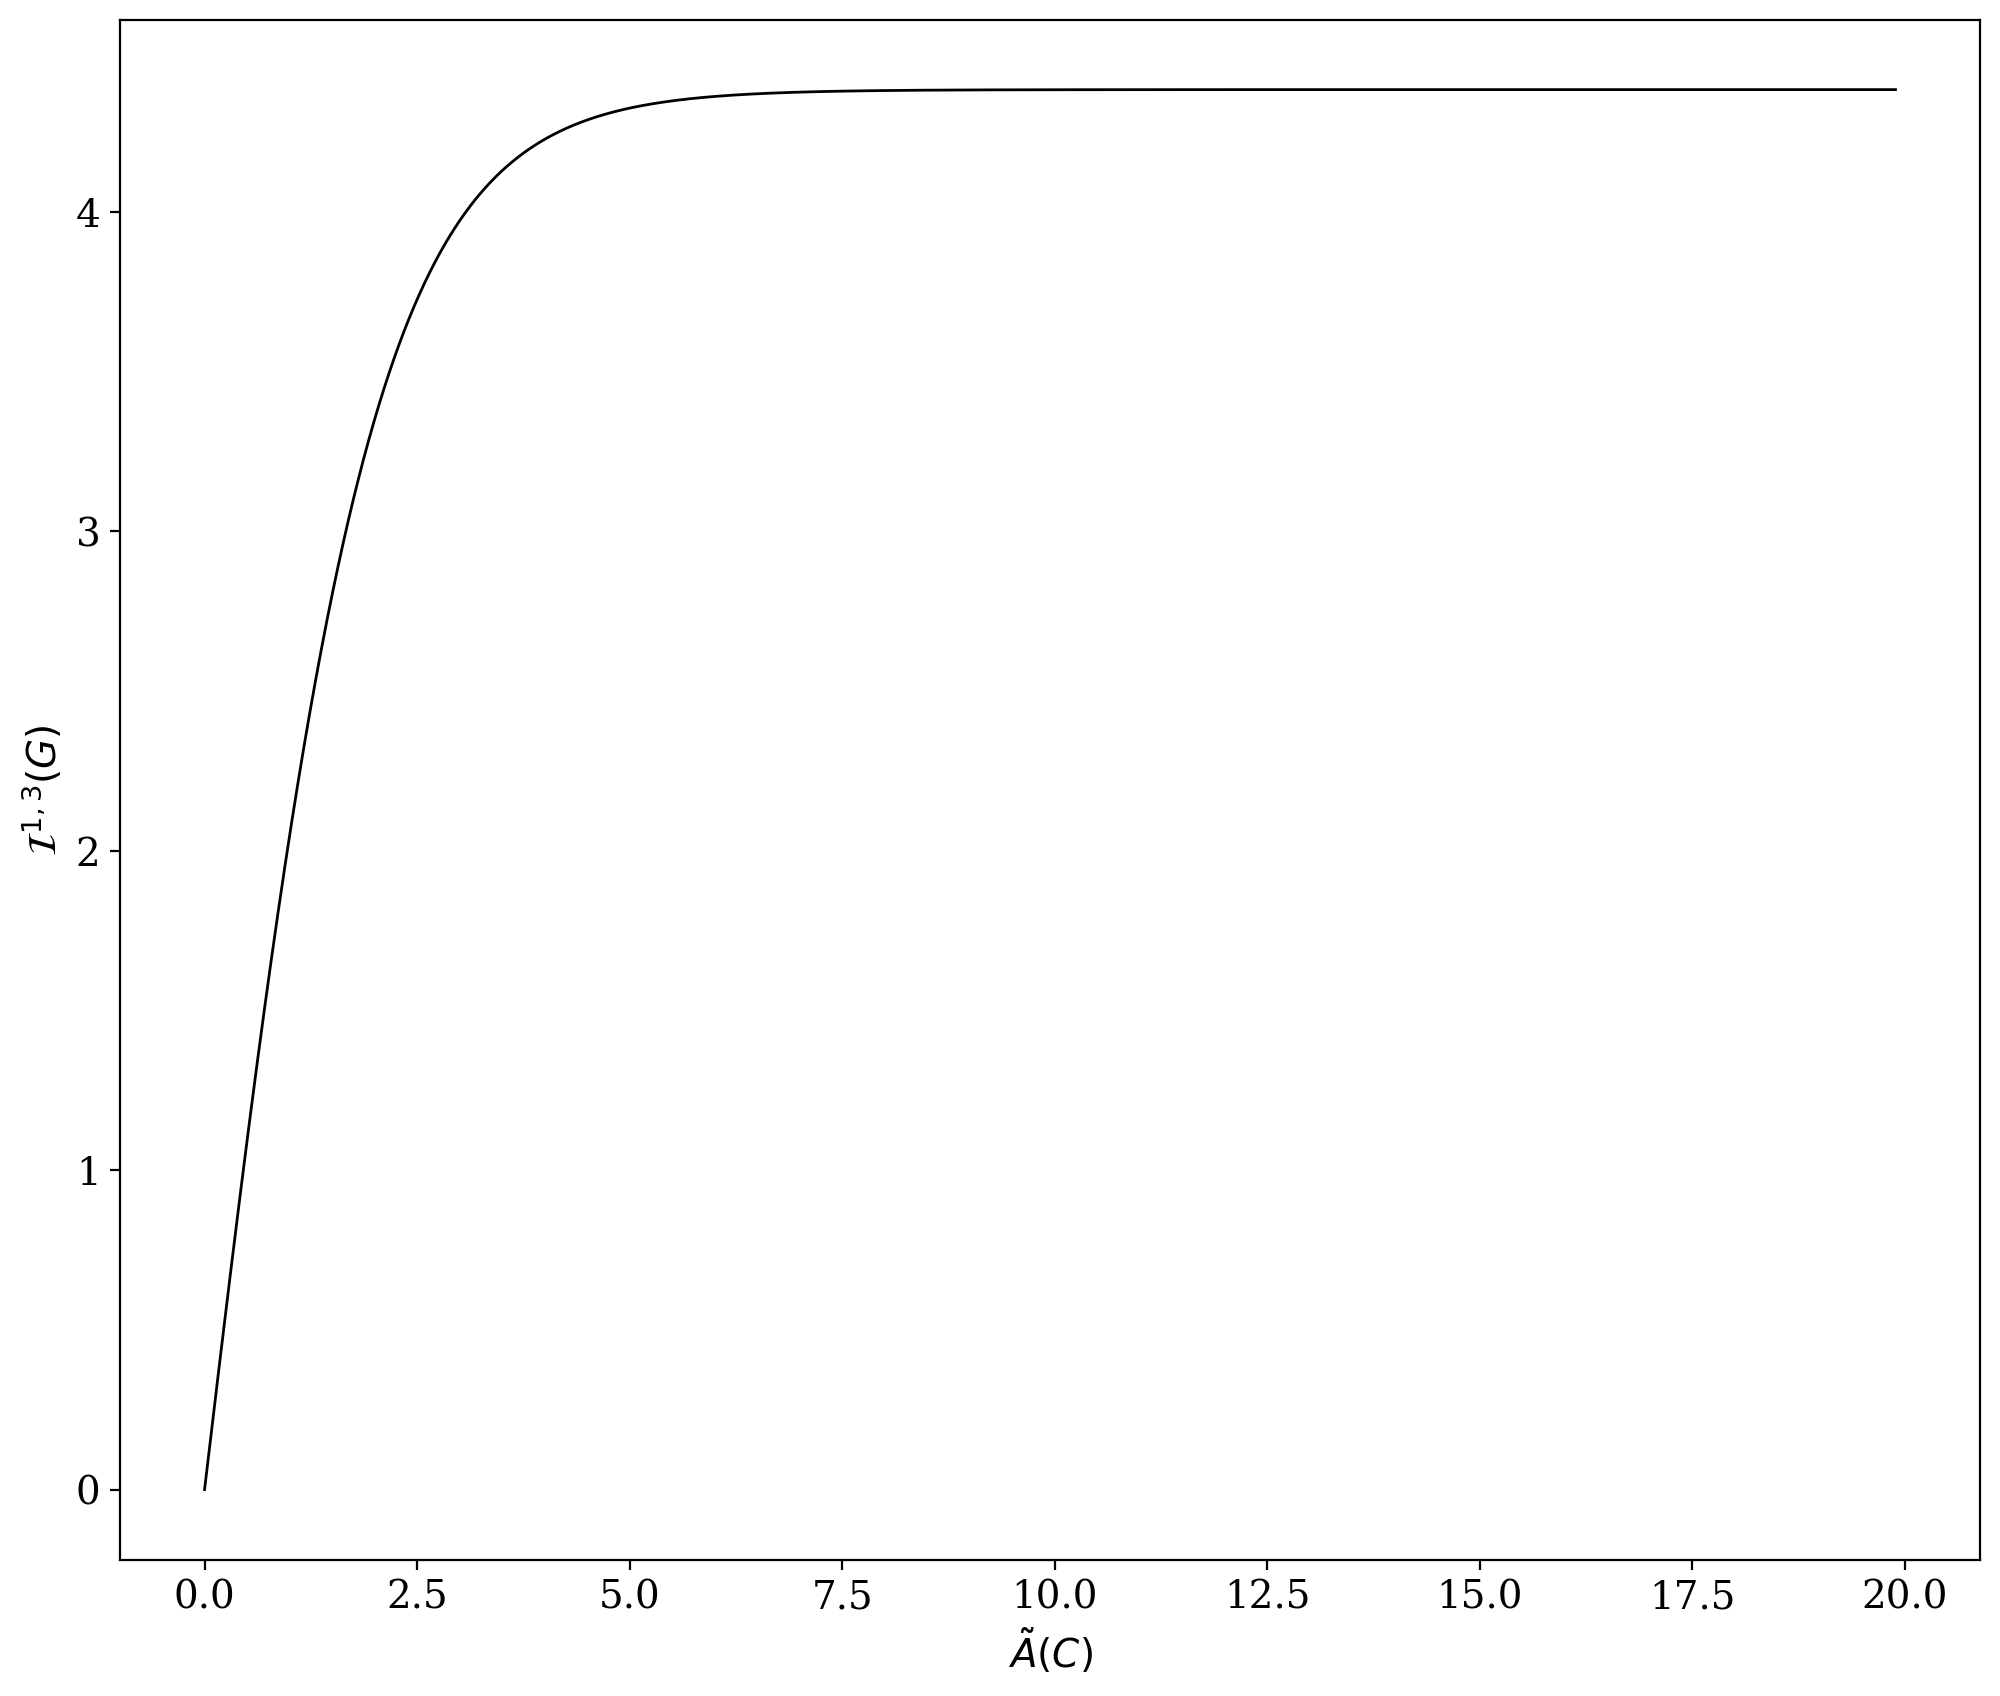

In [27]:
# Steinberg curve plot
plt.plot(np.abs(affinities),areas,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

# Parameter set 3

{(1, 2): 5.154, (1, 4): 0.2267, (2, 1): 0.01257, (2, 3): 0.0183547499419828, (3, 4): 2.321, (3, 2): 2.29, (4, 1): 0.4464, (4, 3): 15.02}

    labels_f : list of 4 floats
        Forward rates: [k12, k23, k34, k41]
    labels_r : list of 4 floats
        Reverse rates: [k21, k32, k43, k14]

In [28]:
k12 = 5.154
k34 = 2.321
k41 = 0.4464

k21 = 0.01257
k32 = 2.29
k43 = 15.02
k14 = 0.2267

k23 = (k21 * k32 * k43 * k14) / (k12 * k34 * k41)

labels_f = [k12, k23, k34, k41]
labels_r = [k21, k32, k43, k14]
aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
print(aff)

0.0


In [29]:
print(labels_f)
print(labels_r)

[5.154, 0.0183547499419828, 2.321, 0.4464]
[0.01257, 2.29, 15.02, 0.2267]


In [30]:
lap = lap_k4(labels_f,labels_r)
print(lap)

[[-5.38070000e+00  1.25700000e-02  0.00000000e+00  4.46400000e-01]
 [ 5.15400000e+00 -3.09247499e-02  2.29000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.83547499e-02 -4.61100000e+00  1.50200000e+01]
 [ 2.26700000e-01  0.00000000e+00  2.32100000e+00 -1.54664000e+01]]


In [31]:
# check that eigenvalues are real and distinct (they need to stay this way)
lambdas, w_i, z_i = spectrum_any(lap)
print(lambdas)

[-1.80658798e+01+0.j -5.39012234e+00+0.j -2.03302261e+00+0.j
  1.57605020e-15+0.j]


In [32]:
signal = [3,5,7,9]
alpha, beta  = 1, 3

In [33]:
N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N)
eigvals_all_r = np.zeros((N, 4), dtype=float)
eigvals_all_c = np.zeros((N, 4), dtype=float)

# perturb edge k34
edge_idx = 2
perturb_edge = labels_f[edge_idx]
perturb_edge

2.321

In [34]:
for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    areas[i] = np.abs(steinberg_analytical_area(signal,lap,alpha=1,beta=3))

    lambdas, w_i, z_i = spectrum_any(lap)
    eigvals_all_r[i, :] = np.sort(lambdas.real)
    eigvals_all_c[i, :] = np.sort(lambdas.imag)
    
    perturb_edge *= 1.01

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 9765.72it/s]


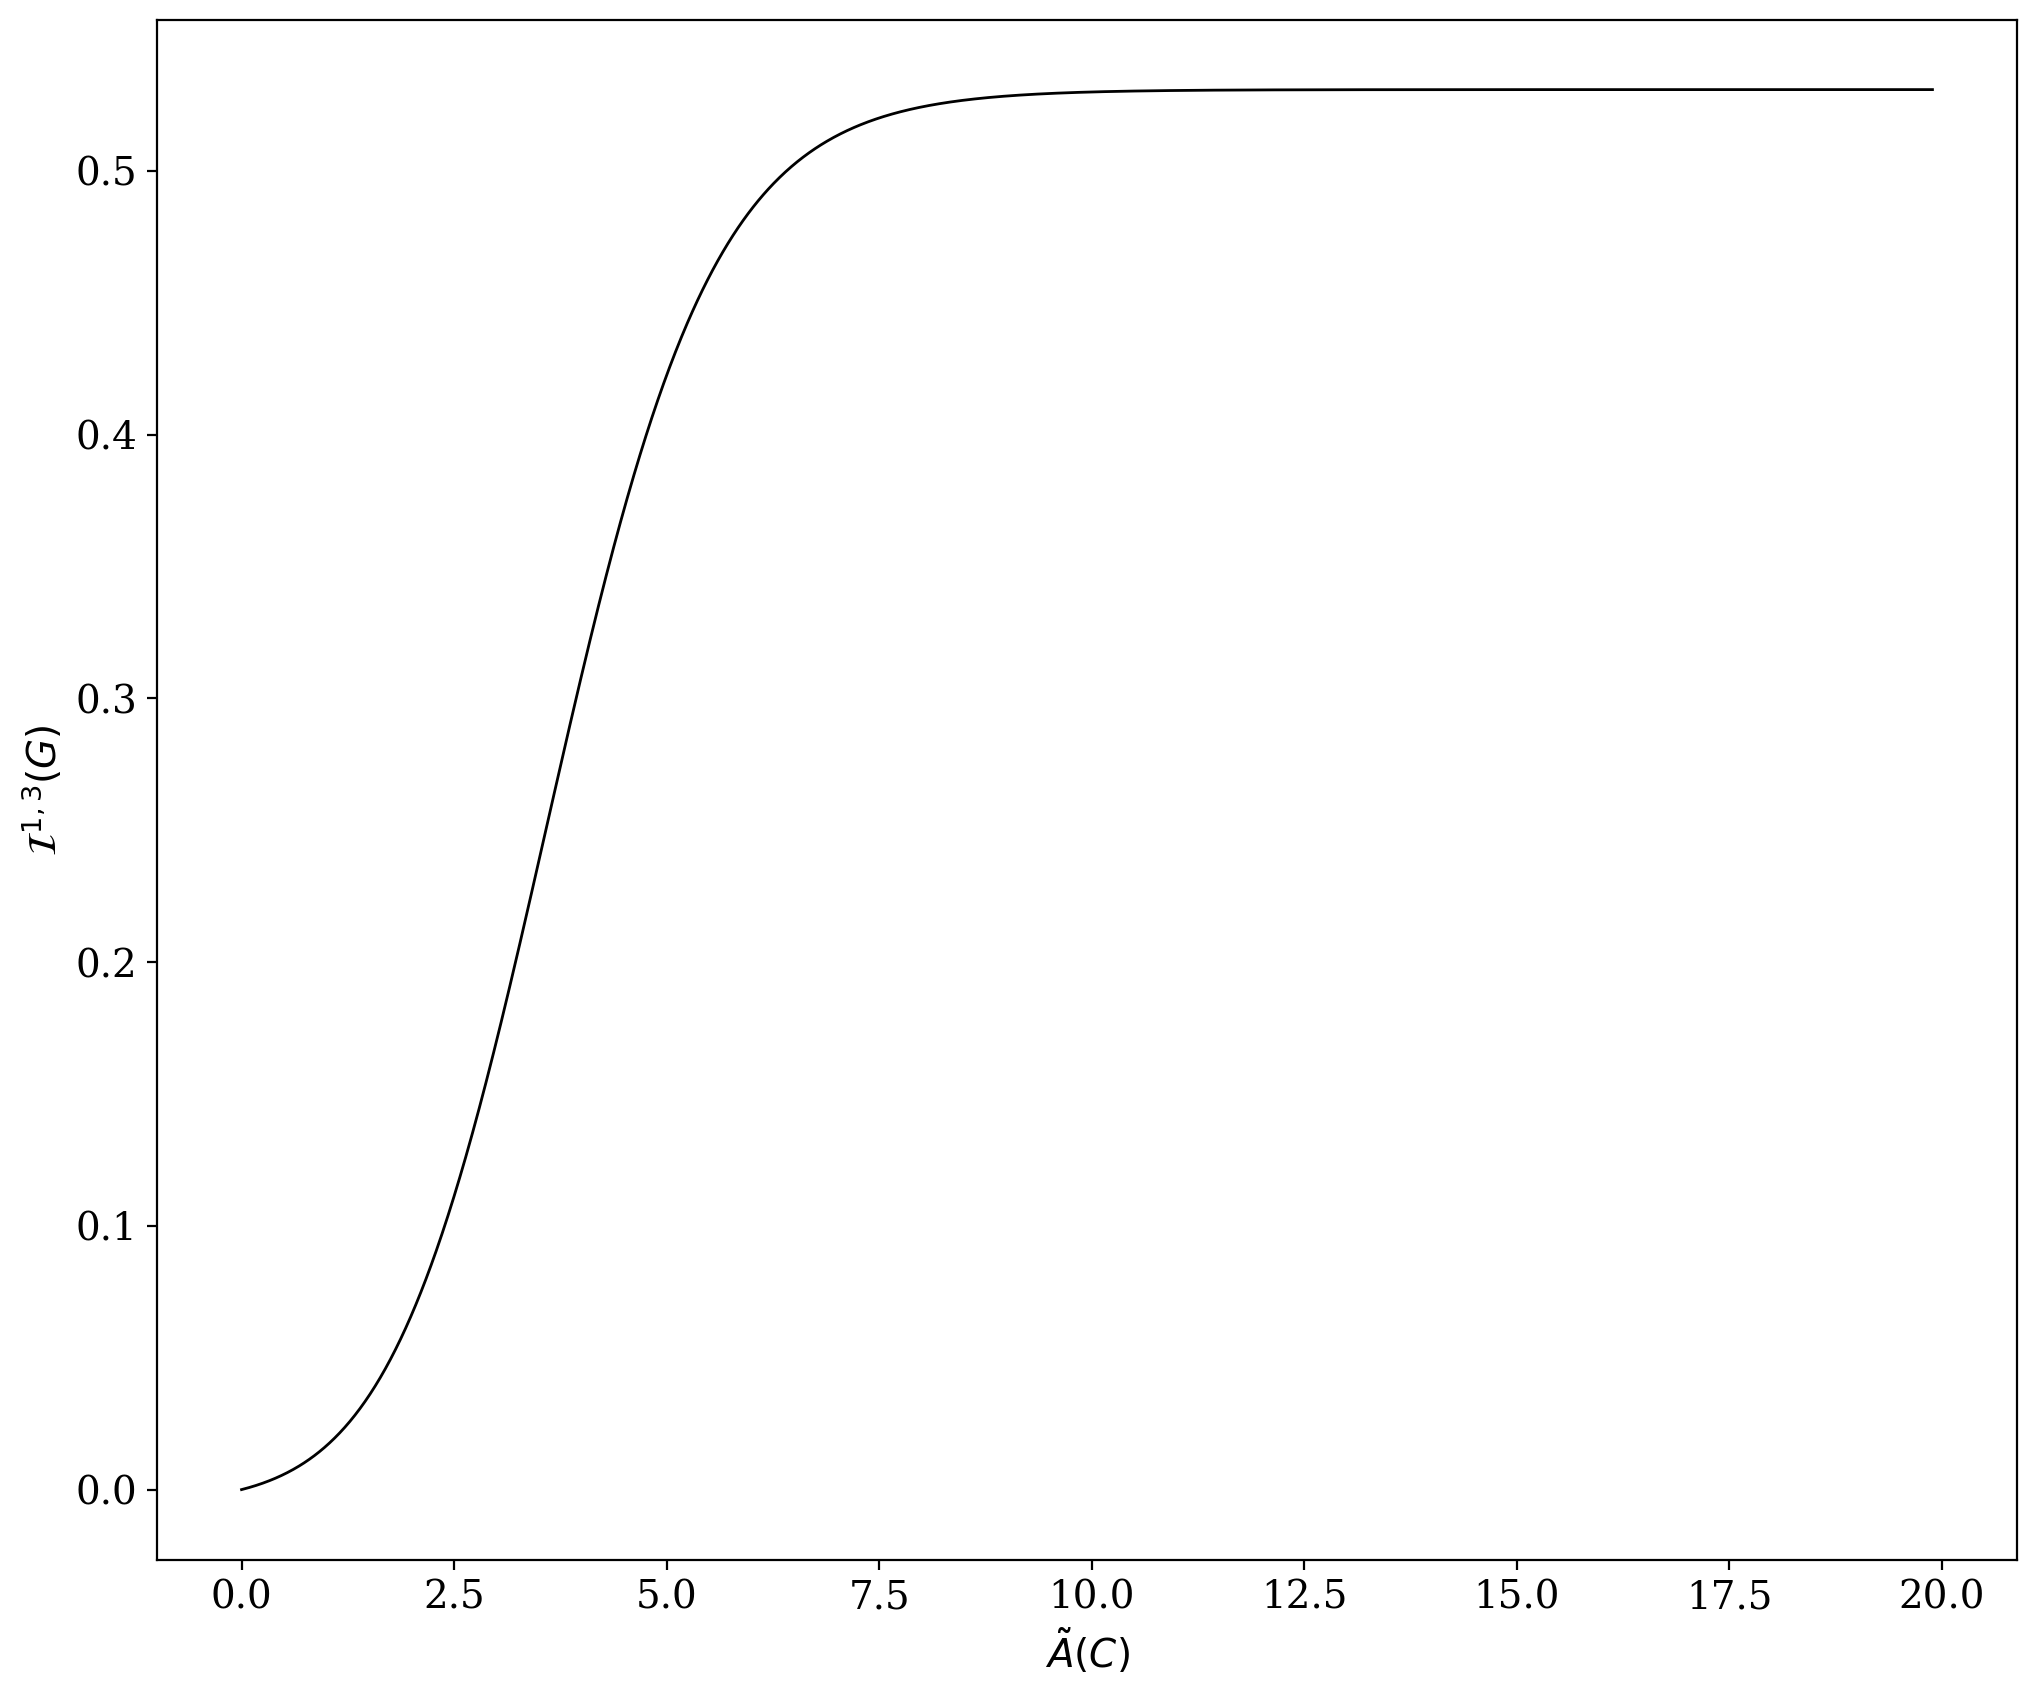

In [35]:
# Steinberg curve plot
plt.plot(np.abs(affinities),areas,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

Hm. So the shape is the same but the magnitude is very different.

# Random parameter sets

In [60]:
labels_f, labels_r = eq_params_k4()
print(labels_f)
print(labels_r)

[0.01142, 0.2238, 10.81, 102.1]
[0.07217, 45.32, 3.836, 0.22482904573117546]


In [61]:
aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
print(aff)

0.0


In [62]:
lap = lap_k4(labels_f,labels_r)
print(lap)

[[-2.36249046e-01  7.21700000e-02  0.00000000e+00  1.02100000e+02]
 [ 1.14200000e-02 -2.95970000e-01  4.53200000e+01  0.00000000e+00]
 [ 0.00000000e+00  2.23800000e-01 -5.61300000e+01  3.83600000e+00]
 [ 2.24829046e-01  0.00000000e+00  1.08100000e+01 -1.05936000e+02]]


In [63]:
# check that eigenvalues are real and distinct (they need to stay this way)
lambdas, w_i, z_i = spectrum_any(lap)
print(lambdas)

[-1.06968278e+02+0.j -5.54982690e+01+0.j -1.31672032e-01+0.j
 -5.93569375e-16+0.j]


In [64]:
signal = [3,5,7,9]
alpha, beta  = 1, 3

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N)
eigvals_all_r = np.zeros((N, 4), dtype=float)
eigvals_all_c = np.zeros((N, 4), dtype=float)

# perturb edge k34
edge_idx = 1
perturb_edge = labels_f[edge_idx]
perturb_edge

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    areas[i] = np.abs(steinberg_analytical_area(signal,lap,alpha=1,beta=3))

    lambdas, w_i, z_i = spectrum_any(lap)
    eigvals_all_r[i, :] = np.sort(lambdas.real)
    eigvals_all_c[i, :] = np.sort(lambdas.imag)
    
    perturb_edge *= 1.01

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 9956.28it/s]


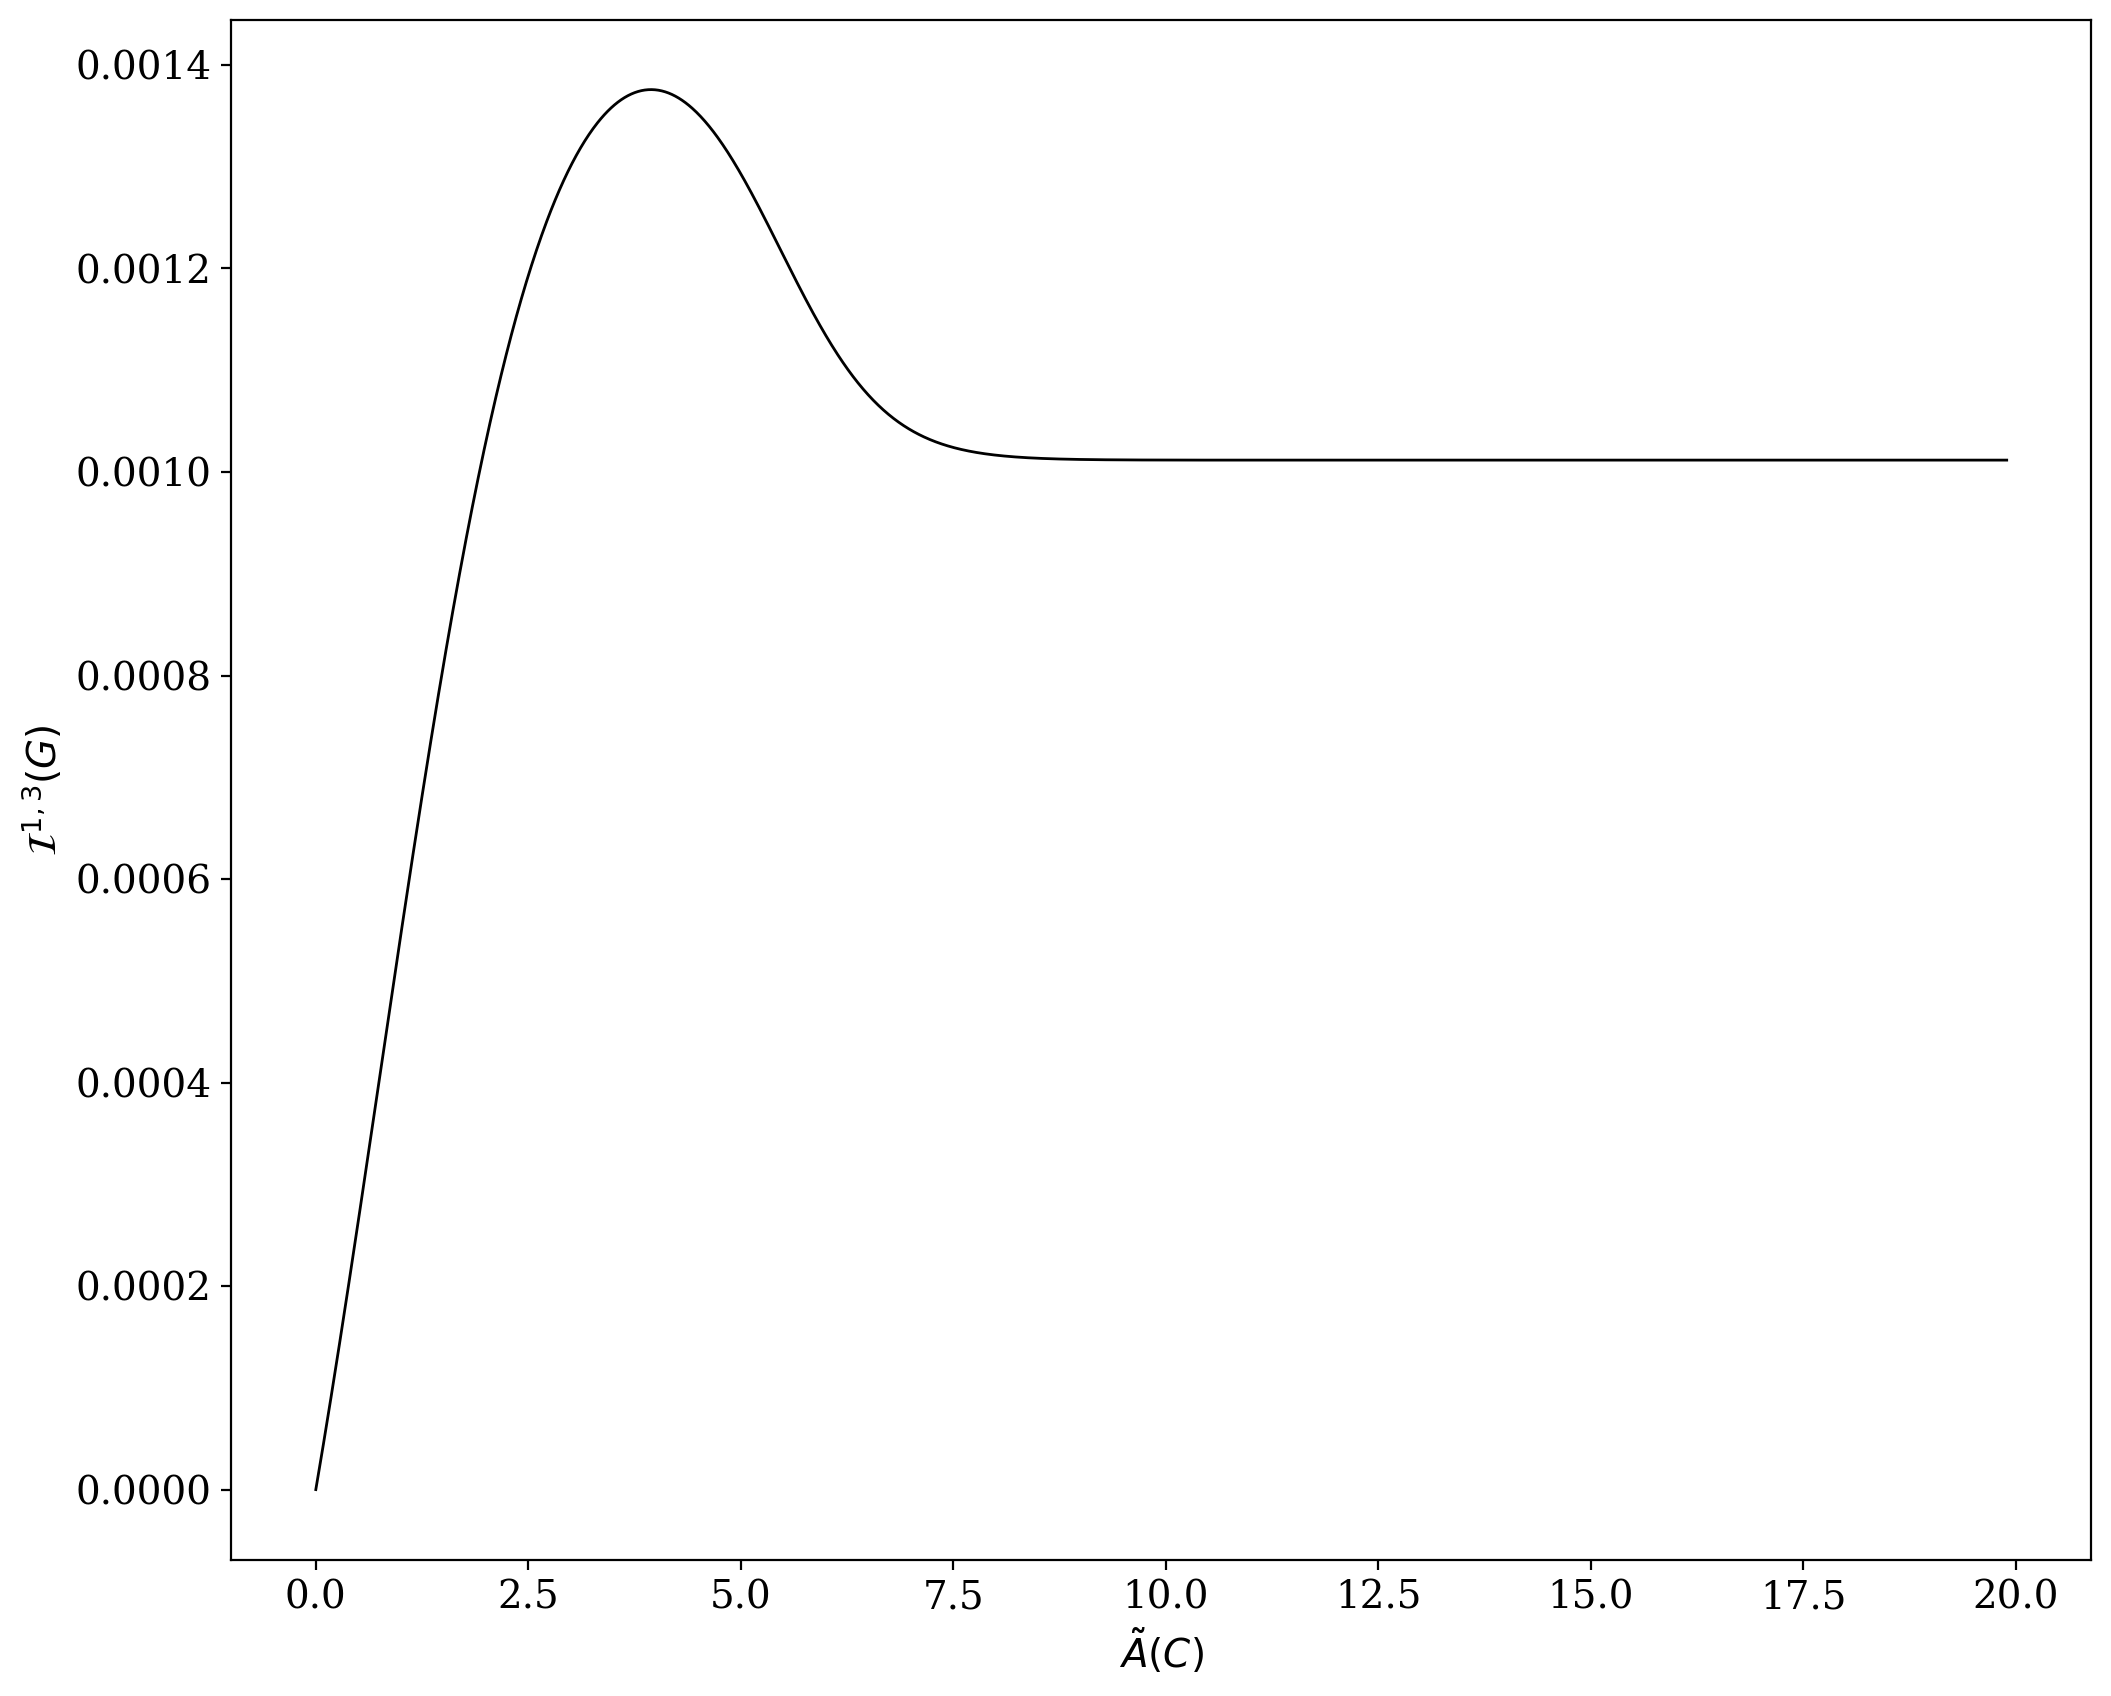

In [65]:
# Steinberg curve plot
plt.plot(np.abs(affinities),areas,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

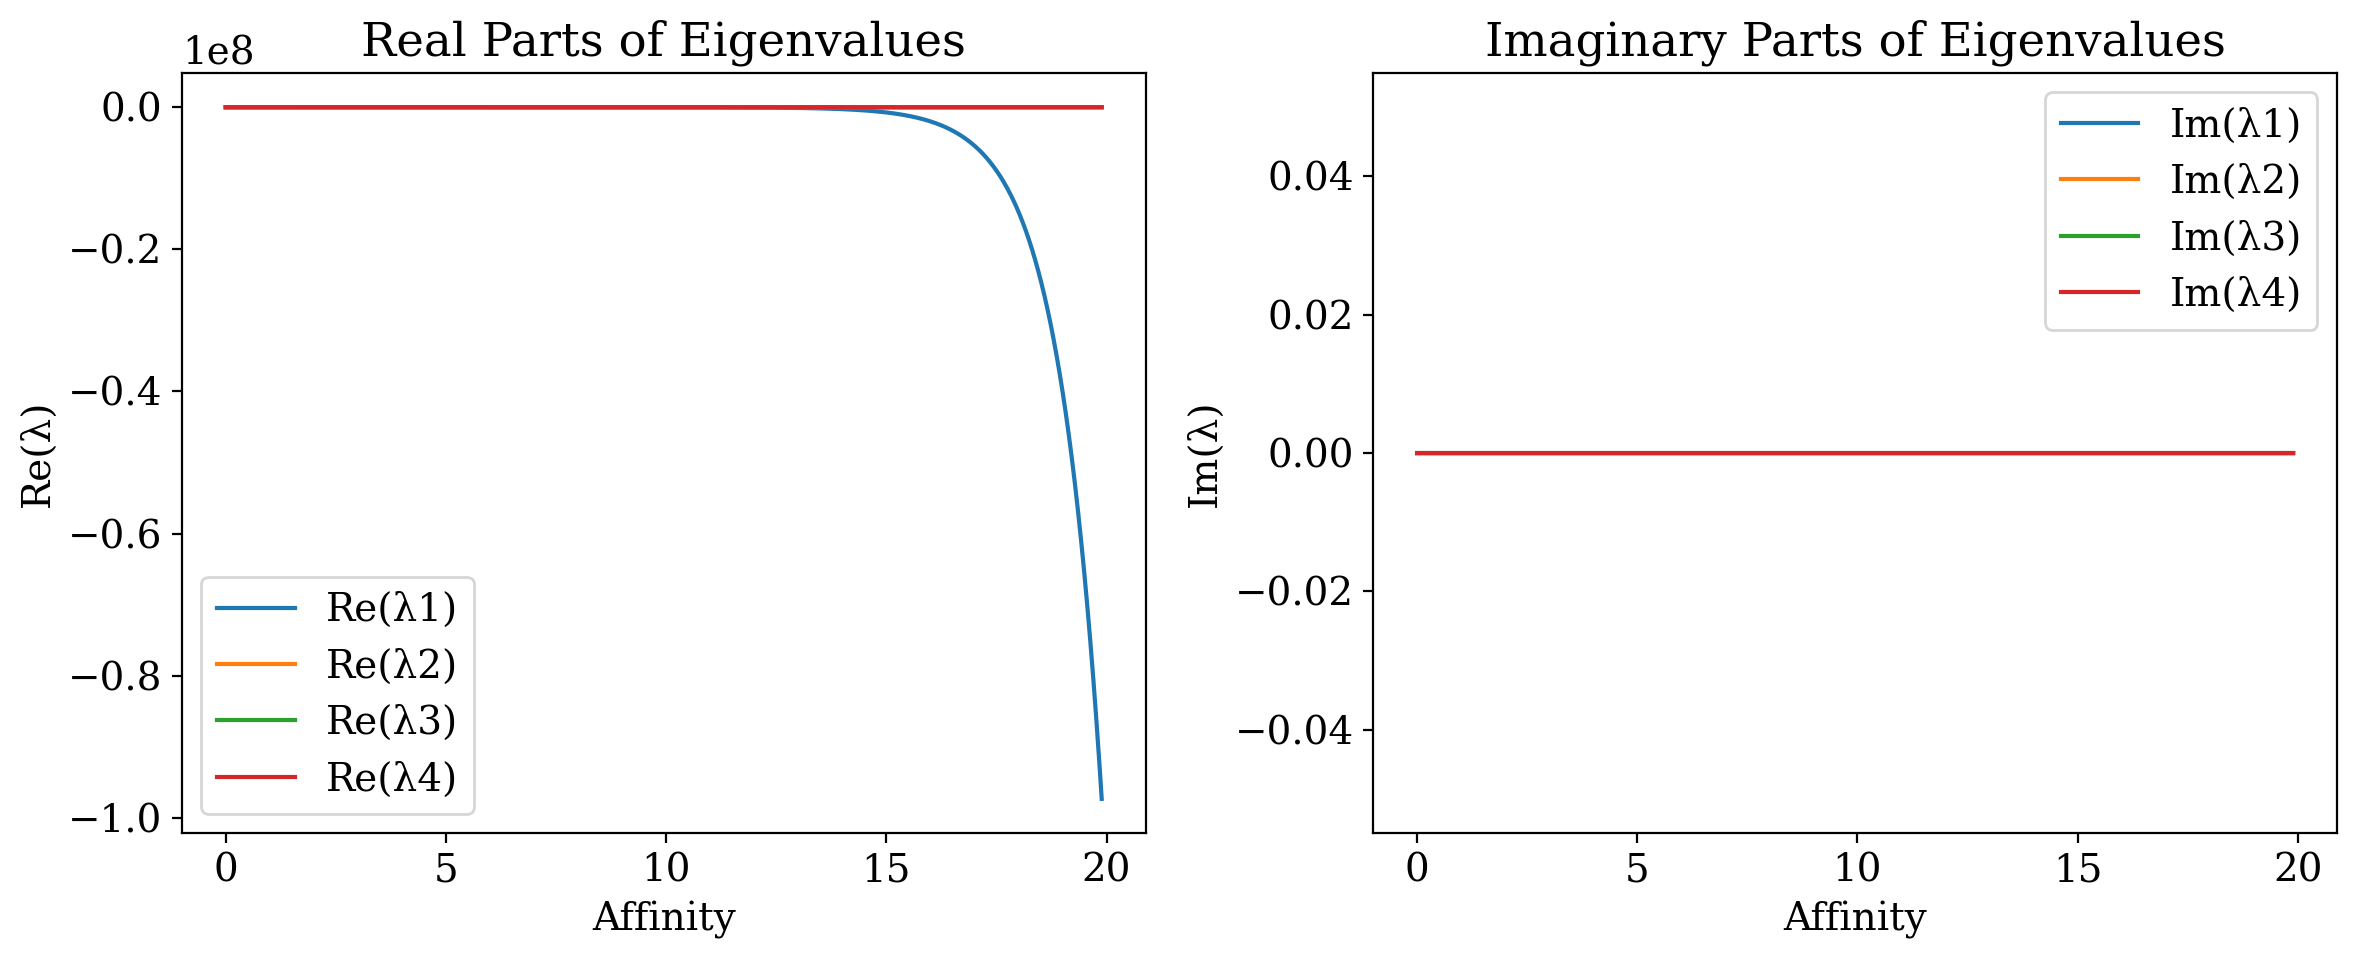

In [66]:
# Eigenvalues plots
plt.figure(figsize=(12,5))

# Real part
plt.subplot(1,2,1)
for j in range(4):
    plt.plot(affinities, eigvals_all_r[:, j], label=f"Re(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Re(λ)")
plt.title("Real Parts of Eigenvalues")
plt.legend()

# Imaginary part
plt.subplot(1,2,2)
for j in range(4):
    plt.plot(affinities, eigvals_all_c[:, j], label=f"Im(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Im(λ)")
plt.title("Imaginary Parts of Eigenvalues")
plt.legend()

plt.tight_layout()
#plt.savefig(f"eigenvalue_evolution_edge_{edge_idx}.png", dpi=300)
plt.show()